## Fahrzeug Positionsbestimmung bei Linearer Bewegung

### Annahmen für das Versuch

Wir fahren mit konstanter Geschwindigkeit. Die Geschwindigkeit kann mittels der Radgeschwindigkeit ermittelt werden.

![KalmanFilter](Kalman-Filter-Step.png)

### Zustandsvektoren

$$
    x_k = 
    \begin{pmatrix}
    x & y & \dot x & \dot y
    \end{pmatrix}
    = 
    \begin{pmatrix}
    X Position & Y Position & v_x & v_y
    \end{pmatrix}
$$


Mit Formeln aus Physik ergibt die Gleichung $ x_{k+1} = Ax_k$:


$$
    x_{k+1} = 
    \begin{pmatrix}
    1 & 0 & \Delta t & 0 \\
    0 & 1 & 0 & \Delta t \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
    \end{pmatrix}
    \begin{pmatrix}
    x \\ y \\ \dot x \\ \dot y
    \end{pmatrix}
$$

Unsere Beobachtungsmodell ist $ y = Gx $:

$$
    y =
    \begin{pmatrix}
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1
    \end{pmatrix}
    *
    x
$$
Das bedeutet wir beobachten die Geschwindigkeit in der richtigen Einheit.

### Startzustand $x_0$

$$
    x_0 =
    \begin{pmatrix}
    0 \\
    0 \\
    0 \\
    0 \\
    \end{pmatrix}
$$

mit

$$
    \Sigma_0 = 
    \begin{pmatrix}
    \sigma _{x}^2 & 0 & 0 & 0 \\
    0 & \sigma _{y}^2 & 0 & 0 \\
    0 & 0 & \sigma _{\dot x}^2 & 0 \\
    0 & 0 & 0 & \sigma _{\dot y}^2
    \end{pmatrix}
$$
ist der Unsicherheitsmatrix (Kovarianzmatrix) in Schritt $k = 0$ mit $\sigma$ Standardabweichung.

In [1]:
using LinearAlgebra, Plots, DataFrames, Distributions
# plotly()
upscale = 1
default(line = (:steppre, 0.5, 1, 2), size=(800*upscale,600*upscale))

In [51]:
x_0 = zeros(4, 1)
Σ_0 = Matrix{Float64}(I, 4, 4) .* 1000

4×4 Array{Float64,2}:
 1000.0     0.0     0.0     0.0
    0.0  1000.0     0.0     0.0
    0.0     0.0  1000.0     0.0
    0.0     0.0     0.0  1000.0

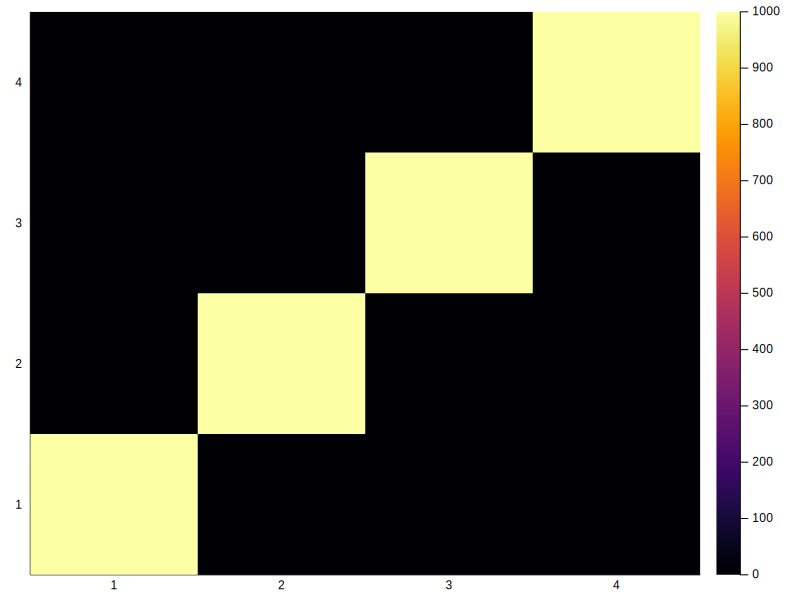

In [52]:
heatmap(Σ_0, seriescolor = :inferno, xticks = (4:-1:1))

### Zustandsübergangsmatrix $A$

// In jedem (Zeit-)Berechnungsschritt muss das Zustandsübergangsmatrix $ A $ neu berechnet werden. -->


In [54]:
Δ_t = 0.1
A = [1 0 Δ_t 0;
     0 1 0 Δ_t;
     0 0 1 0;
     0 0 0 1]

4×4 Array{Float64,2}:
 1.0  0.0  0.1  0.0
 0.0  1.0  0.0  0.1
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

### Messmatrix $ G $

Wir messen $\dot x$ und $\dot y$ direkt.

In [55]:
G = [0 0 1 0;
     0 0 0 1]


2×4 Array{Int64,2}:
 0  0  1  0
 0  0  0  1

### Messrauschen Kovarianz $R$

R zeigt, wie genau die Messung war.

$$
    R =
    \begin{pmatrix}
    \sigma_{\dot x}^2 & 0 \\
    0 & \sigma_{\dot y}^2
    \end{pmatrix}
$$

In [56]:
σ = 10^2
R = [σ 0;
     0 σ]

2×2 Array{Int64,2}:
 100    0
   0  100

### Prozessrauschen Kovarianzmatrix $Q$

Die Position des Fahrzeugs wird von äußeren Faktoren beeinflusst, wie z. B. der Wind oder rutschige Fahrbahn. Dies kann man mithilfe des Kovarianzmatrixes $Q$ modelliert werden.

$$
    Q = \begin{pmatrix}\sigma_{x}^2 & \sigma_{xy} & \sigma_{x \dot x} & \sigma_{x \dot y} \\ \sigma_{yx} & \sigma_{y}^2 & \sigma_{y \dot x} & \sigma_{y \dot y} \\ \sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\ \sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2 \end{pmatrix}
$$

$Q$ kann berechnet werden als $ Q = G \cdot G^T \cdot \sigma_v^2$ mit 
$G = \begin{pmatrix}0.5dt^2 & 0.5dt^2 & dt & dt\end{pmatrix}^T$ und $\sigma_v$ als die Beschleunigungsprozessrauschen. Diese kann nach  Schubert, R., Adam, C., Obst, M., Mattern, N., Leonhardt, V., & Wanielik, G. (2011). Empirical evaluation of vehicular models for ego motion estimation als $8.8 m/s^2$ angenähert werden.

In [7]:
σ_v = 8.8
Gravity = transpose([ 0.5 * Δ_t^2 0.5 * Δ_t^2 Δ_t Δ_t ])
Q = Gravity * transpose(Gravity) * σ_v^2

4×4 Array{Float64,2}:
 0.001936  0.001936  0.03872  0.03872
 0.001936  0.001936  0.03872  0.03872
 0.03872   0.03872   0.7744   0.7744 
 0.03872   0.03872   0.7744   0.7744 

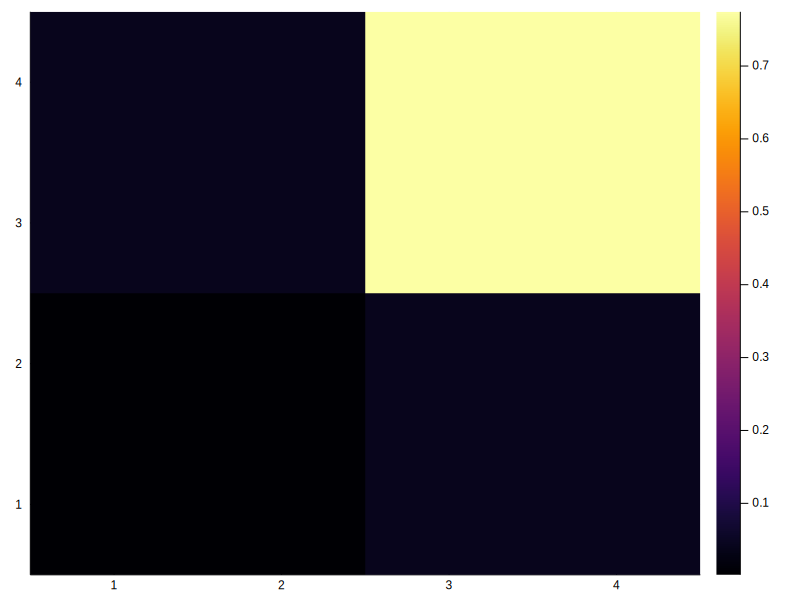

In [8]:
heatmap(Q)

### Messdaten
Im nächsten Schritt generieren wir messdaten.

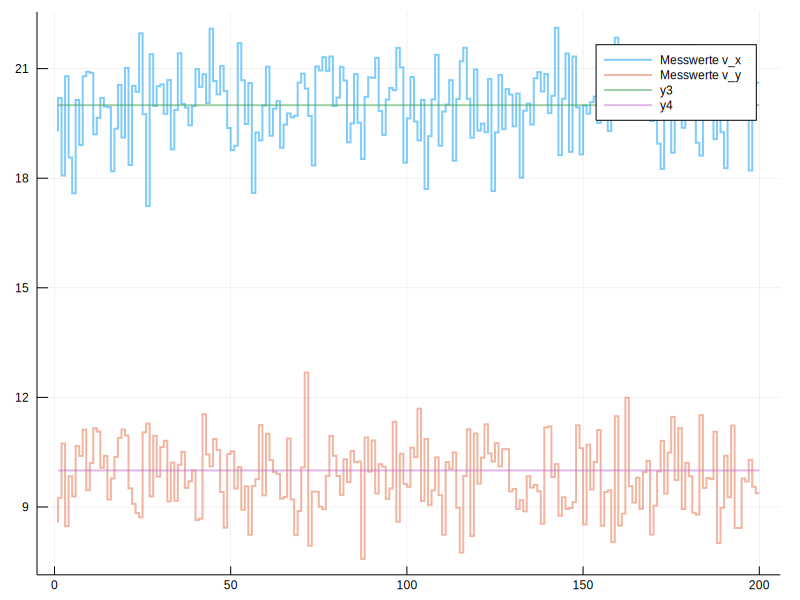

In [9]:
n = 200
v_x = 20
v_y = 10

m_x = rand(Normal(0, 1), n, 1) .+ v_x
m_y = rand(Normal(0, 1), n, 1) .+ v_y

plot(1:200, m_x, label = "Messwerte v_x", line = (:steppre, 0.5, 1, 2))
plot!(1:200, m_y, label = "Messwerte v_y", line = (:steppre, 0.5, 1, 2))
plot!(1:200, (x) -> 20)
plot!(1:200, (x) -> 10)

In [41]:
include("../KalmanFilter.jl")

Main.KalmanFilter

In [34]:
A * x_0

4×1 Array{Float64,2}:
 0.0
 0.0
 0.0
 0.0

In [35]:
A * Σ_0 * A' + Q

4×4 Array{Float64,2}:
 1010.0          0.001936   100.039       0.03872
    0.001936  1010.0          0.03872   100.039  
  100.039        0.03872   1000.77        0.7744 
    0.03872    100.039        0.7744   1000.77   

In [42]:
model = KalmanFilter.Kalman(A, Q, G, R, x_0, Σ_0)
KalmanFilter.predict(model)

(state = [0.0; 0.0; 0.0; 0.0], cov = [1010.0 0.001936 100.039 0.03872; 0.001936 1010.0 0.03872 100.039; 100.039 0.03872 1000.77 0.7744; 0.03872 100.039 0.7744 1000.77])

In [43]:
model = KalmanFilter.Kalman(A, Q, G, R, x_0, Σ_0)
y(i) = [m_x[i]; m_y[i]]
predicted = zeros(Float64, 4, n)
fusioned = zeros(Float64, 4, n)
confidence = zeros(Float64, 4, 4, n)
gains = zeros(Float64, 2, 4, n)
for i = 1:n
    y_cur = y(i)
    n = KalmanFilter.next(model, y_cur)
    fusioned[:, i] = n.fusioned
    predicted[:, i] = n.predicted
    model = n.model
end
output = DataFrame(fusioned', [:pX, :pY, :vX, :vY])

plt = plot(1, xlim = (0, 400), ylim = (0, 200), label = "Gefilterte Laufbahn")
plot!((x) -> 0.5x, linestyle = :dot, seriestype = :line, label = "Theoretische Laufbahn")
@gif for i = eachrow(output)
    push!(plt, i.pX, i.pY)
end

k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [0.0; 0.0; 0.0; 0.0], [1000.0 0.0 0.0 0.0; 0.0 1000.0 0.0 0.0; 0.0 0.0 1000.0 0.0; 0.0 0.0 0.0 1000.0], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [1.75254; 0.778161; 17.5352; 7.7914], [1000.91 0.00129418 9.08803 -0.00287595; 0.00129418 1000.91 -0.00287595 9.08803; 9.08803 -0.00287595 90.9155 0.006391; -0.00287595 9.08803 0.006391 90.9155], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0],

true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [45.0089; 23.0431; 19.6852; 10.1349], [1022.92 0.0221956 9.71225 -0.244457; 0.0221956 1022.92 -0.244457 9.71225; 9.71225 -0.244457 8.05185 3.72285; -0.244457 9.71225 3.72285 8.05185], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [47.0464; 23.9286; 19.6896; 10.0572], [1023.92 0.0225007 9.71027 -0.248237; 0.0225007 1023.92 -0.248237 9.71027; 9.71027 -0.248237 7.95321 3.80384; -0.248237 9.71027 3.80384 7.95321], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilt

true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [89.6111; 44.9555; 20.1743; 10.2509], [1044.93 0.024782 9.69836 -0.279464; 0.024782 1044.93 -0.279464 9.69836; 9.69836 -0.279464 6.95619 4.73889; -0.279464 9.69836 4.73889 6.95619], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [91.674; 46.0385; 20.2371; 10.3164], [1045.93 0.0248056 9.69839 -0.279917; 0.0248056 1045.93 -0.279917 9.69839; 9.69839 -0.279917 6.9321 4.76291; -0.279917 9.69839 4.76291 6.9321], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Ka

true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [133.241; 66.6732; 19.7927; 9.85717], [1066.93 0.0249884 9.7003 -0.284799; 0.0249884 1066.93 -0.284799 9.7003; 9.7003 -0.284799 6.59253 5.10222; -0.284799 9.7003 5.10222 6.59253], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [135.21; 67.5961; 19.7512; 9.80793], [1067.93 0.0249909 9.70039 -0.284922; 0.0249909 1067.93 -0.284922 9.70039; 9.70039 -0.284922 6.58159 5.11316; -0.284922 9.70039 5.11316 6.58159], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Ka

true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [177.682; 88.0356; 19.9557; 9.88302], [1088.93 0.0250179 9.70203 -0.286749; 0.0250179 1088.93 -0.286749 9.70203; 9.70203 -0.286749 6.40854 5.28621; -0.286749 9.70203 5.28621 6.40854], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [179.756; 89.0297; 20.0117; 9.93103], [1089.93 0.0250186 9.70209 -0.286813; 0.0250186 1089.93 -0.286813 9.70209; 9.70209 -0.286813 6.40231 5.29244; -0.286813 9.70209 5.29244 6.40231], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilt

true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [221.704; 109.829; 19.8074; 9.72857], [1110.93 0.0250297 9.70313 -0.287868; 0.0250297 1110.93 -0.287868 9.70313; 9.70313 -0.287868 6.29742 5.39733; -0.287868 9.70313 5.39733 6.29742], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [223.704; 110.85; 19.8477; 9.77142], [1111.93 0.0250302 9.70317 -0.287908; 0.0250302 1111.93 -0.287908 9.70317; 9.70317 -0.287908 6.29341 5.40134; -0.287908 9.70317 5.40134 6.29341], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilte

true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [265.375; 131.702; 19.7823; 9.73163], [1132.93 0.0250372 9.70387 -0.288612; 0.0250372 1132.93 -0.288612 9.70387; 9.70387 -0.288612 6.22303 5.47172; -0.288612 9.70387 5.47172 6.22303], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [267.362; 132.593; 19.7397; 9.68226], [1133.93 0.0250375 9.7039 -0.28864; 0.0250375 1133.93 -0.28864 9.7039; 9.7039 -0.28864 6.22023 5.47452; -0.28864 9.7039 5.47452 6.22023], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalma

true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [309.648; 153.209; 20.0101; 9.91728], [1154.93 0.0250426 9.70441 -0.289145; 0.0250426 1154.93 -0.289145 9.70441; 9.70441 -0.289145 6.16975 5.525; -0.289145 9.70441 5.525 6.16975], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [311.673; 154.061; 19.9437; 9.8404], [1155.93 0.0250428 9.70443 -0.289166; 0.0250428 1155.93 -0.289166 9.70443; 9.70443 -0.289166 6.16768 5.52707; -0.289166 9.70443 5.52707 6.16768], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Ka

true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [353.995; 174.509; 19.9498; 9.80934], [1176.93 0.0250466 9.70481 -0.289545; 0.0250466 1176.93 -0.289545 9.70481; 9.70481 -0.289545 6.1297 5.56505; -0.289545 9.70481 5.56505 6.1297], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [356.093; 175.618; 20.0924; 9.95333], [1177.93 0.0250467 9.70482 -0.289561; 0.0250467 1177.93 -0.289561 9.70482; 9.70482 -0.289561 6.12812 5.56663; -0.289561 9.70482 5.56663 6.12812], UniformScaling{Bool}
true*I, 1)
k = Main.KalmanFilter

true*I, 1)
k = Main.KalmanFilter.Kalman([1.0 0.0 0.1 0.0; 0.0 1.0 0.0 0.1; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.001936 0.001936 0.03872 0.03872; 0.001936 0.001936 0.03872 0.03872; 0.03872 0.03872 0.7744 0.7744; 0.03872 0.03872 0.7744 0.7744], [0 0 1 0; 0 0 0 1], [100 0; 0 100], [397.899; 195.864; 19.8481; 9.69563], [1198.93 0.0250497 9.70512 -0.289857; 0.0250497 1198.93 -0.289857 9.70512; 9.70512 -0.289857 6.0985 5.59624; -0.289857 9.70512 5.59624 6.0985], UniformScaling{Bool}
true*I, 1)


┌ Info: Saved animation to 
│   fn = /home/meszlenyilorant/bachelorarbeit/notebooks/03.carposition/tmp.gif
└ @ Plots /home/meszlenyilorant/.julia/packages/Plots/UQI78/src/animation.jl:90


Plots.AnimatedGif("/home/meszlenyilorant/bachelorarbeit/notebooks/03.carposition/tmp.gif")

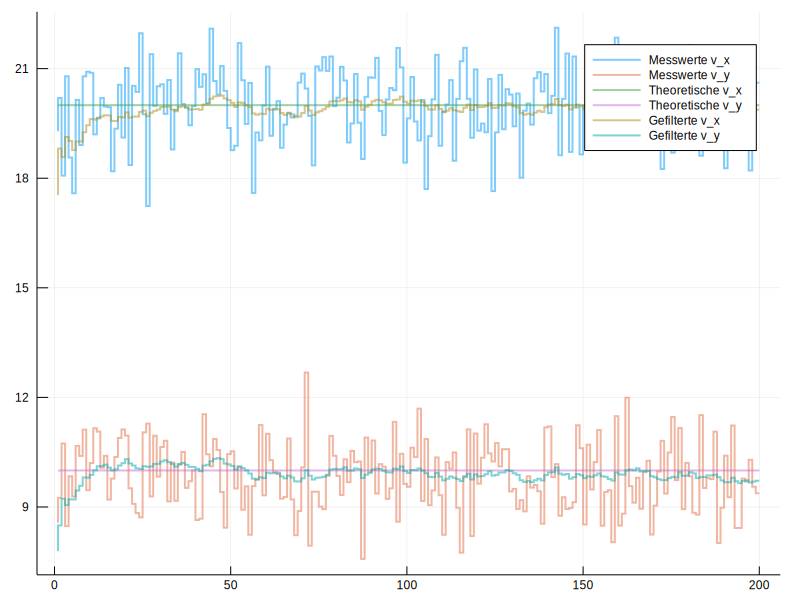

In [44]:
plot(1:200, m_x, label = "Messwerte v_x", line = (:steppre, 0.5, 1, 2))
plot!(1:200, m_y, label = "Messwerte v_y", line = (:steppre, 0.5, 1, 2))
plot!(1:200, (x) -> 20, label = "Theoretische v_x")
plot!(1:200, (x) -> 10, label = "Theoretische v_y")
plot!(1:200, output.vX, label = "Gefilterte v_x")
plot!(1:200, output.vY, label = "Gefilterte v_y")